# Layer specific DMG
- Within each brain region, the DMG specific to each layer

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dmg_result = pd.read_msgpack('./ITSpatialPairwiseDEG/TotalPairwiseMarker.msg')
dmg_result['FromRegion'] = dmg_result['cluster_from'].apply(lambda i: i.split('+')[1])
dmg_result['FromLayer'] = dmg_result['cluster_from'].apply(lambda i: i.split('+')[0])
dmg_result['ToRegion'] = dmg_result['cluster_to'].apply(lambda i: i.split('+')[1])
dmg_result['ToLayer'] = dmg_result['cluster_to'].apply(lambda i: i.split('+')[0])

# only select DMG within each region
dmg_result = dmg_result[dmg_result['FromRegion'] == dmg_result['ToRegion']].copy()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
group_mch_level = pd.read_msgpack('./ITSpatialPairwiseDEG/ClusterMean.genes.msg')
dmg_result['gene_mcg_from'] = dmg_result.apply(
    lambda i: group_mch_level.at[i['cluster_from'], i['gene_id']], axis=1)
dmg_result['gene_mcg_to'] = dmg_result.apply(
    lambda i: group_mch_level.at[i['cluster_to'], i['gene_id']], axis=1)
dmg_result = dmg_result[dmg_result['gene_mcg_from'] < dmg_result['gene_mcg_to']].copy()

In [4]:
# further filtering
dmg_result = dmg_result[(dmg_result['AUROC'] > 0.85) & 
                        (dmg_result['gene_mcg_from'] < 1.2) & 
                        (dmg_result['gene_mcg_to'] > 0.8) & 
                        ((dmg_result['gene_mcg_to'] - dmg_result['gene_mcg_from']) > 0.5)].copy()

In [5]:
repeat_counts = dmg_result.groupby(['FromLayer', 'ToLayer', 'gene_name']).apply(lambda i: i.shape[0])
repeat_counts.name = 'Count'
layer_compare_repeats_in_region = repeat_counts.reset_index()

In [6]:
dmg_result.to_csv('LayerSpecificDMG.csv', index=None)

## Assign to each group

- In all the pairwise comparisons related to a gene, if the COI only appears in sig hypo side but not in sig hyper side, then the gene is assign to hypo gene group of this COI

In [7]:
layer_hypo_genes = {}
for gene, gene_df in dmg_result.groupby('gene_id'):
    pass_layer = set(gene_df['FromLayer'].unique()) - set(gene_df['ToLayer'].unique())
    for layer in pass_layer:
        layer_hypo_genes.setdefault(layer, set()).add(gene)

records = {}
# shared markers
for layer, genes in layer_hypo_genes.items():
    for layer2, genes2 in layer_hypo_genes.items():
        records[(layer, layer2)] = len(genes & genes2)
pd.Series(records).unstack()

,IT-L23,IT-L4,IT-L5,IT-L6
IT-L23,596,139,121,118
IT-L4,139,308,127,40
IT-L5,121,127,453,96
IT-L6,118,40,96,412


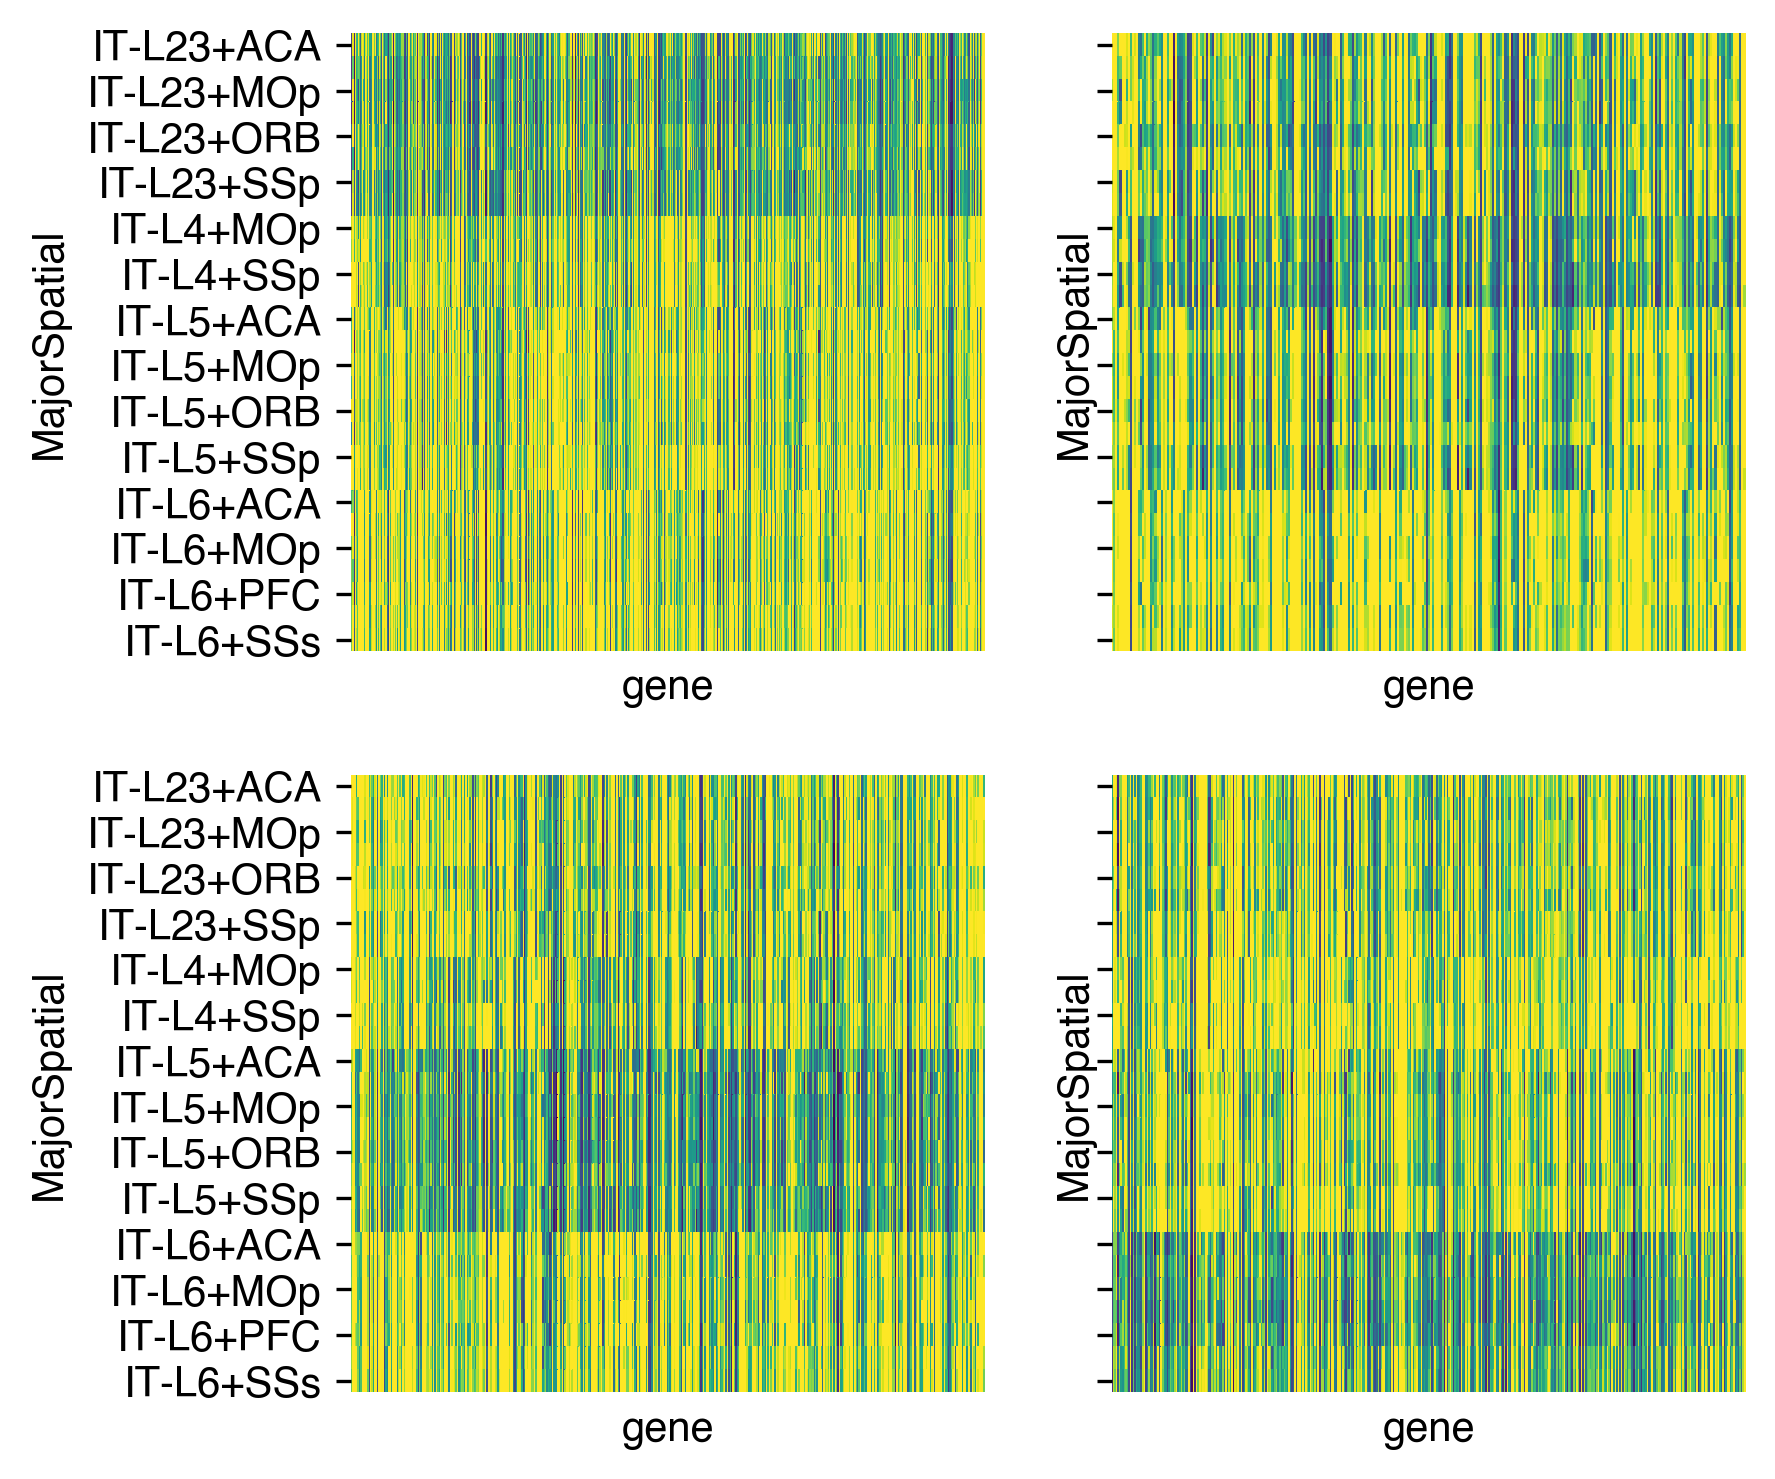

In [8]:
fig, axes = plt.subplots(figsize=(6, 6), dpi=300, nrows=2, ncols=2, sharey=True)
for ax, layer in zip(axes.flat, ['IT-L23', 'IT-L4', 'IT-L5', 'IT-L6']):
    sns.heatmap(group_mch_level[layer_hypo_genes[layer]], 
                vmin=0.3, vmax=1.5, ax=ax, cbar=False, cmap='viridis')
    ax.set(xticks=[])

In [9]:
import joblib
joblib.dump(layer_hypo_genes, 'layer_hypo_genes.obj')

['layer_hypo_genes.obj']